<a href="https://colab.research.google.com/github/sueoglu/gobi_gwas/blob/main/malena_sb/malena_sb_gwas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#setup
!pip install pandas-plink limix-lmm

In [2]:
#setup
import numpy as np
import pdb
from pandas_plink import read_plink
from limix_lmm import LMM
import pylab as plt
import os
import pandera.pandas as pd

In [3]:
#setup
import scipy
import scipy.stats as st

if not hasattr(scipy, 'dot'):
    scipy.dot = np.dot
if not hasattr(scipy, 'einsum'):
    scipy.einsum = np.einsum
if not hasattr(scipy, 'log'):
    scipy.log = np.log
if not hasattr(scipy, 'sign'):
    scipy.sign = np.sign
if not hasattr(scipy, 'sqrt'):
    scipy.sqrt = np.sqrt

In [4]:
#download data
!wget -O ALL.chr22_GRCh38.genotypes.20170504.zip  "https://www.dropbox.com/scl/fi/2j079oew31gwd2hzajlil/ALL.chr22_GRCh38.genotypes.20170504.zip?rlkey=7307x4sjq9lkvhwu3aivh5uut&e=1&dl=0"
!unzip -o -q ALL.chr22_GRCh38.genotypes.20170504.zip && rm ALL.chr22_GRCh38.genotypes.20170504.zip

--2026-02-09 14:15:22--  https://www.dropbox.com/scl/fi/2j079oew31gwd2hzajlil/ALL.chr22_GRCh38.genotypes.20170504.zip?rlkey=7307x4sjq9lkvhwu3aivh5uut&e=1&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc00a57544b6abcbfc0a78540797.dl.dropboxusercontent.com/cd/0/inline/C6m4HFZu7GeeY0Hd7d5NF5wGNy5wWW6XLACyZcegMvR0HM5VDs4QXluFB76J5DJtnD8K9ZT1pdE686xw--eQGNklbOXkFcBiQ_BCgRL1KGOM1FLebC-2tpfp-c2UE8jR20g/file# [following]
--2026-02-09 14:15:23--  https://uc00a57544b6abcbfc0a78540797.dl.dropboxusercontent.com/cd/0/inline/C6m4HFZu7GeeY0Hd7d5NF5wGNy5wWW6XLACyZcegMvR0HM5VDs4QXluFB76J5DJtnD8K9ZT1pdE686xw--eQGNklbOXkFcBiQ_BCgRL1KGOM1FLebC-2tpfp-c2UE8jR20g/file
Resolving uc00a57544b6abcbfc0a78540797.dl.dropboxusercontent.com (uc00a57544b6abcbfc0a78540797.dl.dropboxusercontent.com)... 162.125.3.15, 2620:100:601

In [5]:
#load data
file = 'ALL.chr22_GRCh38.genotypes.20170504'
bim, fam, G = read_plink(file)

Mapping files: 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]
/usr/local/lib/python3.12/dist-packages/pandera/_pandas_deprecated.py:146: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


# Preprocessing

In [ ]:
#preprocessing
#remove indivs with lots of missing(NAN) values (5%)
fraction_of_missing_indivs = np.isnan(G).mean(axis=0) # average number of NA values across variants
keep_indivs = fraction_of_missing_indivs <0.05 #keep the ones with less than 5%
G = G[:, keep_indivs] #filter
fam = fam.iloc[keep_indivs].reset_index(drop=True) #locate the indiv to keep and repair the index


In [ ]:
#preprocessing
#remove SNPs missing in many indivs (5%)
fraction_of_missing_SNPs = np.isnan(G).mean(axis=1) #average freq of snp across indivs
keep_SNPs = fraction_of_missing_SNPs <0.05 #keep the ones with less than 5%
G = G[keep_SNPs, :] #filter
bim = bim.iloc[keep_SNPs].reset_index(drop=True) #locate SNPs to keep and repair the index

In [ ]:
#preprocessing
#remove rare variants (maf<5%)
allele_freq = np.nanmean(G, axis=1)/2 #average snp freq across indivs, ignor NA
maf = np.minimum(allele_freq, 1-allele_freq) #find minor allele
keep_maf = maf >= 0.05 #keep snps with maf> 5%
G = G[keep_maf, :] #filter
bim = bim.iloc[keep_maf].reset_index(drop=True) #locate SNPs to keep and repair the index

In [ ]:
#preprocessing
#remove duplicate SNPs (same position)
duplicate = bim.duplicated(subset=['chrom', 'pos']) #check for duplicate chromosome and pos pairs (add boolean column "duplicate")
G.compute_chunk_sizes()
G = G[~duplicate, :] #filter (keep first occ)
bim = bim.loc[~duplicate].reset_index(drop=True)

# Subsetting(?)

In [102]:
#all this is earlier gwas code
def extract_region(bim, G, chrom, start, end):
    I1 = bim['chrom']==str(chrom)
    I2 = bim['pos'] > start
    I3 = bim['pos'] < end
    Ikeep = I1 * I2 * I3
    bim = bim.loc[Ikeep].copy()
    G = G[bim['i'].values]
    bim['i'] = np.arange(len(bim))
    return bim, G

In [103]:
def subset_individuals(fam, G, keep_idxs):
    fam = fam.iloc[keep_idxs]
    G = G[:, keep_idxs]
    return bim, G

In [104]:
# subset to 1000 individuals
N = 1000
np.random.seed(0)
idxs = np.sort(np.random.permutation(fam.shape[0])[:N])
fams, Gs = subset_individuals(fam, G, idxs)

In [105]:
# extract region
chrom = 22
start = 30797531
size = 100000
bimr, Gr = extract_region(bim, Gs, chrom, start, start + size)

In [106]:
# load genotype matrix
X_real = Gr.compute().T

# Phase 1: Phenotype Simulation


In [108]:
#earlier provided gwas code
def simulate_pheno(X, idx_caus, var_expl, direction=None):
    # Ensure that the number of causal variant indices matches the number of variances explained.
    assert len(idx_caus) == len(var_expl)

    # If no direction is provided, randomly assign a positive or negative direction for each causal variant.
    if direction is None:
        direction = 2. * (np.random.rand(len(idx_caus)) > 0.5) - 1.
    # Ensure that the number of directions matches the number of causal variant indices.
    assert len(idx_caus) == len(direction)

    # Compute the remaining variance after accounting for the variance explained by the causal variants.
    ve = 1 - var_expl.sum()
    # Ensure that the total variance explained by causal variants is less than 1.
    assert ve > 0, 'sum(var_expl) should be < 1'

    # Compute the effect sizes for the causal variants based on the variance they explain and their direction.
    beta = np.sqrt(var_expl) * direction

    # Extract the columns of X corresponding to the causal variants and standardize them.
    Xc = X[:, idx_caus]
    Xc = (Xc - Xc.mean(0)) / Xc.std(0)

    # Compute the genetic component of the phenotype.
    yg = Xc.dot(beta)[:, None]
    # Compute the noise component of the phenotype.
    yn = np.sqrt(ve) * np.random.randn(X.shape[0], 1)

    # Sum the genetic and noise components to get the simulated phenotype.
    y = yg + yn

    # Initialize the real effect sizes for all variants in X as zeros.
    beta_real = np.zeros(X.shape[1])
    # Update the real effect sizes for the causal variants.
    beta_real[idx_caus] = beta

    # Standardize the phenotypic values to have mean 0 and standard deviation 1.
    ystd = y.std()
    y = (y - y.mean()) / ystd
    # Adjust the real effect sizes accordingly after standardizing y.
    beta_real = beta_real / ystd

    return y, beta_real

In [109]:
#earlier provided gwas code
#Vary parameters
n_causal = 100
h2 = 0.6

#10 causal SNPs
idx_caus = np.random.choice(X_real.shape[1], size=n_causal, replace=False)
var_expl = np.repeat(h2/n_causal, n_causal)

y, beta_real = simulate_pheno(X_real, idx_caus, var_expl)

ValueError: a must be greater than 0 unless no samples are taken

In [97]:
#earlier provided gwas code
# Perform genetic association testing
F = np.ones_like(y)
lmm = LMM(y, F)
lmm.process(X_real)
pv = lmm.getPv()
beta = lmm.getBetaSNP()
beta_ste = lmm.getBetaSNPste()

In [98]:
#earlier provided gwas code
def qq_plot(p_values, figsize, title): #parameters changed
    """
    Create a QQ plot given a list of p-values.

    Parameters:
    - p_values: list of p-values
    - figsize: size of the plot
    - title: title for the plot
    """

    # Sort p-values
    observed = -np.log10(np.sort(p_values))
    expected = -np.log10(np.arange(1, len(p_values) + 1) / (len(p_values) + 2))

    # Create the QQ plot
    if figsize is not None: #added
      plt.figure(figsize=figsize) #added
    plt.scatter(expected, observed, marker='.')
    plt.plot([0, max(expected)], [0, max(expected)], color='red', linestyle='--')
    plt.xlabel('Expected -log10(P-value)')
    plt.ylabel('Observed -log10(P-value)')
    plt.title(title)

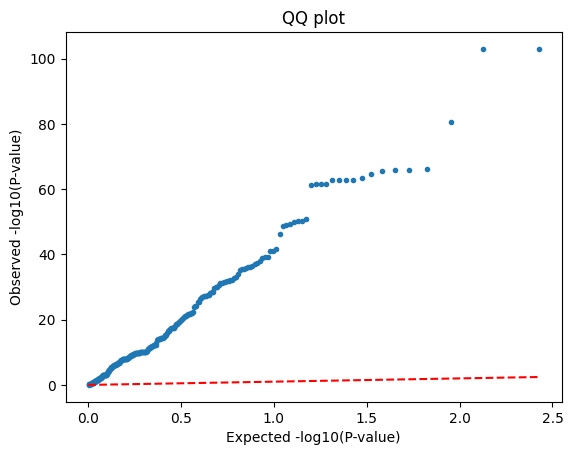

In [99]:
#earlier provided gwas code
qq_plot(pv, None, 'QQ plot')
plt.show()

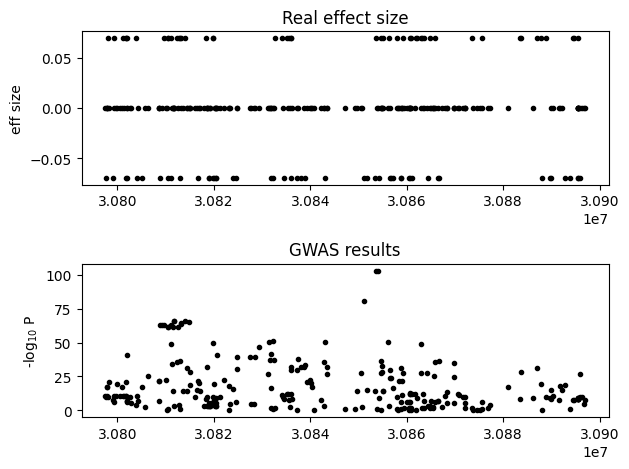

In [101]:
#earlier provided gwas code
# Plot ground truth and results
x = bimr['pos'].values
plt.subplot(211)
plt.title('Real effect size')
plt.plot(x, beta_real, '.k')
plt.ylabel('eff size')
plt.subplot(212)
plt.title('GWAS results')
plt.plot(x, -np.log10(pv), '.k')
plt.ylabel('-log$_{10}$ P')
plt.tight_layout()
plt.show()

# Phase 2: GWAS & Feature Selection

# Phase 3: Model Developement